# NEQR Quantum Circuit Example

**Author: Luis Jose Mantilla Santa Cruz**

In this notebook, we will implement a quantum circuit for the Novel Enhanced Quantum Representation (NEQR) model using Qiskit. We will demonstrate how to encode a small 2x2 grayscale image into a quantum state.

## Reference

For more details on NEQR, please refer to the following article:

- **Title:** NEQR: a novel enhanced quantum representation of digital images
- **Authors:** [Include author names if available]
- **Published:** 26 March 2013
- **Journal:** Quantum Information Processing
- **Volume:** 12, Pages 2833–2860
- **Link:** [NEQR Article on SpringerLink](https://link.springer.com/article/10.1007/s11128-013-0567-z)

## Step 1: Import Libraries

First, we need to import the required libraries from Qiskit and other useful packages.


In [2]:
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator 

from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler

from matplotlib import pyplot as plt
import numpy as np
from qiskit.visualization import plot_histogram

## Step 2: Define the Quantum Circuit

We'll define a quantum circuit for encoding a 2x2 image with a grayscale range of 2. This will use 4 qubits: 2 for the coordinates and 2 for the grayscale values.

The quantum state representing an image of size \(2^n \times 2^n\) can be expressed as:

$$
|I\rangle = \frac{1}{2^n} \sum_{Y=0}^{2^n-1} \sum_{X=0}^{2^n-1} |f(Y, X)\rangle |YX\rangle
$$

where \( f(Y, X) \) is the grayscale value for the pixel at position \((Y, X)\).


In [28]:
def encode_neqr(image_data):
    """Encode a grayscale image using the NEQR method in Qiskit."""
    # Image dimensions
    rows, cols = image_data.shape

    # Number of qubits for coordinates
    num_row_qubits = int(np.ceil(np.log2(rows)))
    num_col_qubits = int(np.ceil(np.log2(cols)))
    num_coordinate_qubits = num_row_qubits + num_col_qubits
    
    # Determine maximum grayscale value to calculate required qubits
    max_grayscale_value = image_data.max()
    num_grayscale_qubits = int(np.ceil(np.log2(max_grayscale_value + 1)))
    
    # Total number of qubits
    num_qubits = num_coordinate_qubits + num_grayscale_qubits
    
    # Create quantum circuit
    circuit = QuantumCircuit(num_qubits, num_qubits)
    
    # Apply Hadamard gates to coordinate qubits
    for qubit in range(num_coordinate_qubits):
        circuit.h(qubit)
    
    # Encode each pixel value into quantum states using controlled operations
    for row in range(rows):
        for col in range(cols):
            pixel_value = image_data[row, col]
            bin_value = format(pixel_value, f'0{num_grayscale_qubits}b')
            
            # Convert row and column to binary indices
            row_bin = format(row, f'0{num_row_qubits}b')
            col_bin = format(col, f'0{num_col_qubits}b')
            coord_bin_indices = row_bin + col_bin
            
            # Apply X gates to set coordinate qubits
            for i, bit in enumerate(coord_bin_indices):
                if bit == '1':
                    circuit.x(i)
            
            # Apply controlled-NOT (CNOT) gates to encode grayscale value
            for k, bit in enumerate(bin_value):
                if bit == '1':
                    # Use coordinate qubits as control for the grayscale qubits
                    circuit.mcx(list(range(num_coordinate_qubits)), num_coordinate_qubits + k)
            
            # Reset the coordinate qubits (if necessary) to superposition
            for i, bit in enumerate(coord_bin_indices):
                if bit == '1':
                    circuit.x(i)

    # Add measurement operations
    circuit.measure(range(num_qubits), range(num_qubits))
    
    return circuit


## Step 3: Encode Pixel Values

We will encode grayscale values and coordinates into the quantum circuit. For simplicity, we assume the pixel values are as follows:

- \( f(0,0) = 0 \)
- \( f(0,1) = 1 \)
- \( f(1,0) = 1 \)
- \( f(1,1) = 0 \)

The function `encode_pixel_value` sets the qubits based on these values. The grayscale value \( f(Y, X) \) for each pixel is encoded using the binary representation:

$$
f(Y, X) = C^0_{YX} C^1_{YX} \ldots C^{q-2}_{YX} C^{q-1}_{YX}
$$

where each \( C^k_{YX} \in \{0, 1\} \) and the value of \( f(Y, X) \) is in the range \([0, 2^q - 1]\).



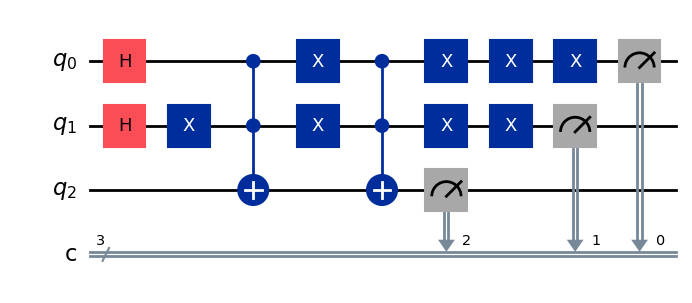

In [150]:
# Create a 2x2 grayscale image with values ranging from 0 to 1
image_data = np.array([[0, 1],
                       [1, 0]])

# Create the NEQR circuit
neqr_circuit = encode_neqr(image_data)
neqr_circuit.draw('mpl')

## Step 4: Simulate the Circuit

We simulate the quantum circuit using Qiskit's QASM simulator to obtain the measurement results, which show how the image is encoded in the quantum state.


In [85]:
def list_of_index_proba(quasi_probs, qubit_num=2):
    list_of_index = []
    list_of_proba = []

    for i in range(0,2**qubit_num):
        list_of_index.append(i)
        if i in quasi_probs:
            list_of_proba.append(quasi_probs[i])
        else:
            list_of_proba.append(0)

    return list_of_index, list_of_proba

def plot_states_quasi_probability(job_result):

    list_a, list_b = list_of_index_proba(job_result.quasi_dists[0],4)
    bit_strings = list(list_a)
    counts = list(list_b)

    # Plot the histogram
    plt.figure(figsize=(16, 2.5))  # Adjust the figure size as needed
    plt.bar(bit_strings, counts)
    plt.xlabel('Particle position')
    plt.ylabel('Probability')
    #plt.title('Histogram of Bit Strings')
    plt.xticks(ticks=range(len(bit_strings)), rotation=90, fontsize=8)  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

In [151]:
sampler = Sampler()
job = sampler.run(circuits=[neqr_circuit], parameter_values=[[]], parameters=[[]])
job_result = job.result()
print(job_result.quasi_dists[0])
#plot_states_quasi_probability_1(job_result)

{0: 0.25, 3: 0.25, 5: 0.25, 6: 0.25}


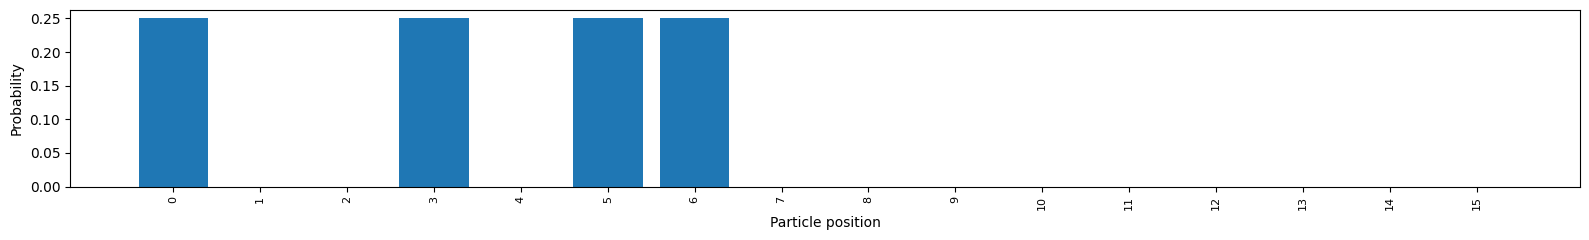

In [152]:
plot_states_quasi_probability(job_result)

In [153]:
job_result

SamplerResult(quasi_dists=[{0: 0.25, 3: 0.25, 5: 0.25, 6: 0.25}], metadata=[{}])

In [162]:
print("Measurement results:")
for key, value in job_result.quasi_dists[0].items():
    print(format(key, f'0{4}b'))

Measurement results:
0000
0011
0101
0110


## Conclusion

In this notebook, we implemented a quantum circuit for the NEQR model using Qiskit. We encoded a simple 2x2 grayscale image into the quantum state and visualized the results.

The resulting quantum state allows for efficient representation and processing of image data in a quantum system.

For further reading on NEQR, refer to the article: [NEQR: a novel enhanced quantum representation of digital images](https://link.springer.com/article/10.1007/s11128-013-0567-z)
